Copyright (c) Microsoft Corporation.

Licensed under the MIT License.

# Generate Sythetic SEGY files for testing

This notebook builds the test data used by the convert_segy unit tests. It covers just a few of the SEG-Y files that could be encountered if you bring your own SEG-Y files for training. This is not a comprehensive set of files so there still may be situations where the segyio or the convert_segy.py utility would fail to load the SEG-Y data.

In [1]:
import segyio
import numpy as np
from glob import glob
from os import listdir
import os
import pandas as pd
import re
import matplotlib.pyplot as pyplot

In [2]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [3]:
def get_segy_details(segyfile):
    with segyio.open(segyfile, ignore_geometry=True) as segy:
        segydf = parse_trace_headers(segy, segy.tracecount)
        print(f"Loaded from file {segyfile}")
        print(f"\tTracecount: {segy.tracecount}")
        print(f"\tData Shape: {segydf.shape}")
        print(f"\tSample length: {len(segy.samples)}")
        pyplot.figure(figsize=(10,6))
        pyplot.scatter(segydf[['INLINE_3D']],segydf[['CROSSLINE_3D']], marker=",")
        pyplot.xlabel('inline')
        pyplot.ylabel('crossline')
        pyplot.show()
        return segydf

In [4]:
def load_segy_with_geometry(segyfile):
    try:
        segy = segyio.open(segyfile, ignore_geometry=False)
        segy.mmap()
        print(f"Loaded with geometry: {segyfile} :")
        print(f"\tNum samples per trace: {len(segy.samples)}")
        print(f"\tNum traces in file: {segy.tracecount}")
    except ValueError as ex:
        print(f"Load failed with geometry: {segyfile} :")
        print(ex)

In [7]:
def create_segy_file(masklambda, filename, sorting=segyio.TraceSortingFormat.INLINE_SORTING, ilinerange=[10,50], xlinerange=[100,300]):
    spec = segyio.spec()


    # to create a file from nothing, we need to tell segyio about the structure of
    # the file, i.e. its inline numbers, crossline numbers, etc. You can also add
    # more structural information, but offsets etc. have sensible defautls. This is
    # the absolute minimal specification for a N-by-M volume
    spec.sorting = 2
    spec.format = 1
    spec.samples = range(int(10))
    spec.ilines = range(*map(int, ilinerange))
    spec.xlines = range(*map(int, xlinerange))
    print(f"Written to {filename}")
    print(f"\tinlines: {len(spec.ilines)}")
    print(f"\tcrosslines: {len(spec.xlines)}")

    with segyio.create(filename, spec) as f:
        # one inline consists of 50 traces
        # which in turn consists of 2000 samples
        step = 0.00001
        start = step * len(spec.samples)
        # fill a trace with predictable values: left-of-comma is the inline
        # number. Immediately right of comma is the crossline number
        # the rightmost digits is the index of the sample in that trace meaning
        # looking up an inline's i's jth crosslines' k should be roughly equal
        # to i.j0k
        trace = np.linspace(-1,1,len(spec.samples),True,dtype=np.single)

        if sorting == segyio.TraceSortingFormat.INLINE_SORTING:
            # Write the file trace-by-trace and update headers with iline, xline
            # and offset
            tr = 0
            for il in spec.ilines:
                for xl in spec.xlines:
                    if masklambda(il, xl):
                        f.header[tr] = {
                            segyio.su.offset: 1,
                            segyio.su.iline: il,
                            segyio.su.xline: xl
                        }
                        f.trace[tr] = trace * ((xl / 100.0) + il)
                        tr += 1
                      
            f.bin.update(
                tsort=segyio.TraceSortingFormat.CROSSLINE_SORTING
            )
        else:
            # Write the file trace-by-trace and update headers with iline, xline
            # and offset
            tr = 0
            for il in spec.ilines:
                for xl in spec.xlines:
                    if masklambda(il, xl):
                        f.header[tr] = {
                            segyio.su.offset: 1,
                            segyio.su.iline: il,
                            segyio.su.xline: xl
                        }
                        f.trace[tr] = trace + (xl / 100.0) + il
                        tr += 1
                 
            f.bin.update(
                tsort=segyio.TraceSortingFormat.INLINE_SORTING
            )
        print(f"\ttraces: {tr}")



## Create sample SEG-Y files for testing

1. Control
2. Missing traces on the top-left and bottom right of the geographic field w/ inline sorting
3. Missing traces on the top-left and bottom right of the geographic field w/ crossline sorting
4. Missing trace in the center of the geographic field w/ inline sorting

### Control File

Create a file that has a cuboid shape with traces at all inline/crosslines

Written to ./normalsegy.segy
	inlines: 40
	crosslines: 200
	traces: 8000
Loaded from file ./normalsegy.segy
	Tracecount: 8000
	Data Shape: (8000, 91)
	Sample length: 10


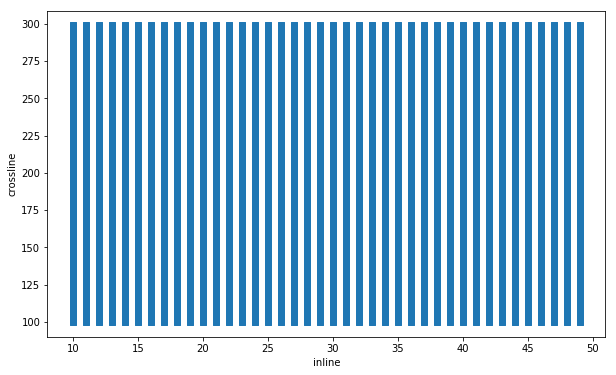

Loaded with geometry: ./normalsegy.segy :
	Num samples per trace: 10
	Num traces in file: 8000


In [8]:
controlfile = './normalsegy.segy'
create_segy_file(lambda il, xl: True, controlfile)
get_segy_details(controlfile)
load_segy_with_geometry(controlfile)

### Inline Error File

inlineerror.segy will throw an error that inlines are not unique because it assumes the same number of inlines per crossline

Written to ./inlineerror.segy
	inlines: 40
	crosslines: 200
	traces: 7309
Loaded from file ./inlineerror.segy
	Tracecount: 7309
	Data Shape: (7309, 91)
	Sample length: 10


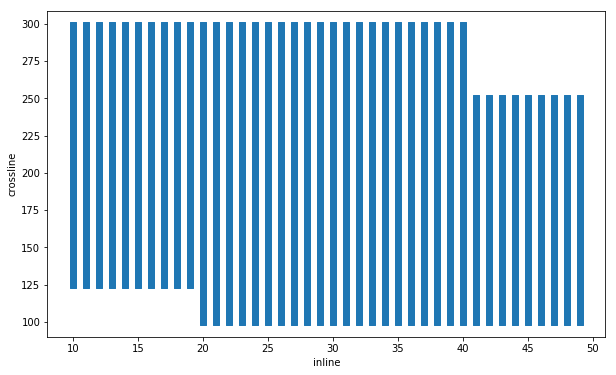

Load failed with geometry: ./inlineerror.segy :
Inlines inconsistent, expect all inlines to be unique


In [9]:
inlinefile = './inlineerror.segy'
create_segy_file(lambda il, xl: not ((il < 20 and xl < 125) or (il > 40 and xl > 250)),
    inlinefile, segyio.TraceSortingFormat.INLINE_SORTING)
get_segy_details(inlinefile)
load_segy_with_geometry(inlinefile)

### Crossline Error File

xlineerror.segy will throw an error that crosslines are not unique because it assumes the same number of crosslines per inline

Written to ./xlineerror.segy
	inlines: 40
	crosslines: 200
	traces: 7309
Loaded from file ./xlineerror.segy
	Tracecount: 7309
	Data Shape: (7309, 91)
	Sample length: 10


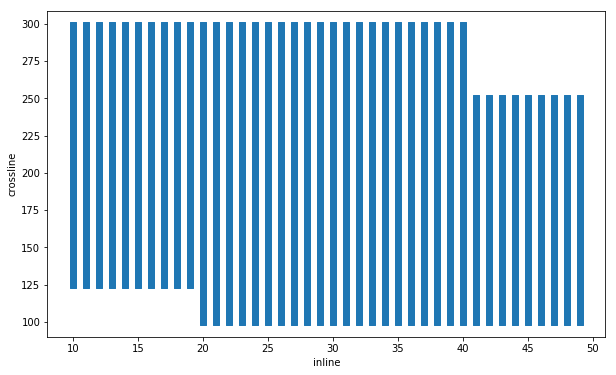

Load failed with geometry: ./xlineerror.segy :
Inlines inconsistent, expect all inlines to be unique


In [10]:
xlineerrorfile = './xlineerror.segy'
create_segy_file(lambda il, xl: not ((il < 20 and xl < 125) or (il > 40 and xl > 250)),
    xlineerrorfile, segyio.TraceSortingFormat.CROSSLINE_SORTING)
get_segy_details(xlineerrorfile)
load_segy_with_geometry(xlineerrorfile)

### Donut whole SEG-Y file

When collecting seismic data, unless in an area of open ocean, it is  rare to be able to collect all trace data from a rectangular field make the collection of traces from a uniform field 


Written to ./donuthole.segy
	inlines: 40
	crosslines: 200
	traces: 7109
Loaded from file ./donuthole.segy
	Tracecount: 7109
	Data Shape: (7109, 91)
	Sample length: 10


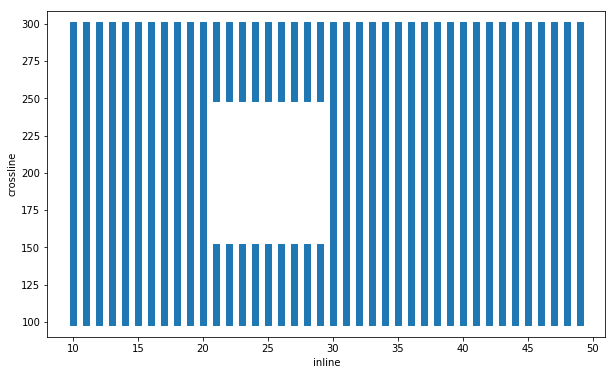

Load failed with geometry: ./donuthole.segy :
Invalid dimensions, ilines (35) * xlines (200) * offsets (1) should match the number of traces (7109)


In [11]:
donuthole_segyfile = './donuthole.segy'
create_segy_file(lambda il, xl: not ((20 < il < 30) and (150 < xl < 250)),
    donuthole_segyfile, segyio.TraceSortingFormat.INLINE_SORTING)
get_segy_details(donuthole_segyfile)
load_segy_with_geometry(donuthole_segyfile)